In [26]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter

In [27]:
@jit(nopython = True)
def init_wave_func(k0_prime, N, T):
    psi = np.zeros((T, N), dtype = np.cdouble)
    i = 1
    while(i < N-1):
        psi[0, i] = np.exp(1j*k0_prime*i)*np.exp((-8*(4*i-N)**2)/N**2)
        i += 1
    norm = compute_norm(psi, 0)
    psi[0] = psi[0]/norm
    return psi

@jit(nopython = True)
def init_potential(k0_prime, lamb, N):
    V_prime = np.zeros(N)
    i = int(2*N/5)
    while(i < 3*N/5):
        V_prime[i] = lamb*k0_prime**2
        i += 1
    return V_prime

@jit(nopython = True)
def compute_norm(psi, n):
    return np.linalg.norm(psi[n])
    
@jit(nopython = True)
def compute_alpha(V_prime, s_prime, N):
    alpha = np.zeros(N, dtype = np.cdouble)
    i = N-1
    while(i > 0):
        alpha[i-1] = -1/(2+(2j/s_prime)-V_prime[i]+alpha[i])
        i -= 1
    return alpha

@jit(nopython = True)
def compute_beta(psi, alpha, V_prime, s_prime, N, n):
    b = np.zeros(N, dtype = np.cdouble)
    beta = np.zeros(N, dtype = np.cdouble)
    i = 0
    while(i < N-1):
        b[i] = 4j*psi[n][i]/s_prime
        i +=1
    i = N-1
    while(i > 0):
        beta[i-1] = (b[i]-beta[i])/(2+(2j/s_prime)-V_prime[i]+alpha[i])
        i -= 1  
    return beta     

@jit(nopython = True)
def compute_chi(alpha, beta, N):
    chi = np.zeros(N, dtype = np.cdouble)
    i = 0
    while(i < N-2):
        chi[i+1] = alpha[i]*chi[i] + beta[i]
        i += 1
    return chi

@jit(nopython = True)
def compute_wave_func(psi, chi, n):
    psi[n+1] = chi - psi[n]
    return psi

@jit(nopython = True)
def iterative_process(T, N, lamb, n_cicles):
    k0_prime = 2*np.pi*n_cicles/N
    s_prime = 1/(4*k0_prime**2)

    psi = init_wave_func(k0_prime, N, T)
    V_prime = init_potential(k0_prime, lamb, N)
    alpha = compute_alpha(V_prime, s_prime, N)

    norm = np.zeros(T)

    i = 0
    while(i < T-1):
        beta = compute_beta(psi, alpha, V_prime, s_prime, N, i)
        chi = compute_chi(alpha, beta, N)
        psi = compute_wave_func(psi, chi, i)
        norm[i] = compute_norm(psi, i)
        i += 1
    return psi, norm, V_prime

@jit(nopython = True)
def prob_density(psi, N, T):
    prob = np.zeros((T, N))
    i = 0
    while(i < T):
        prob[i] = np.absolute(psi[i])
        i += 1
    return prob

In [28]:
N= 1000
n_cicles = int(N/8)
lamb = 0.3
T = 3000

psi, norm, V_prime = iterative_process(T, N, lamb, n_cicles)
prob = prob_density(psi, N, T)

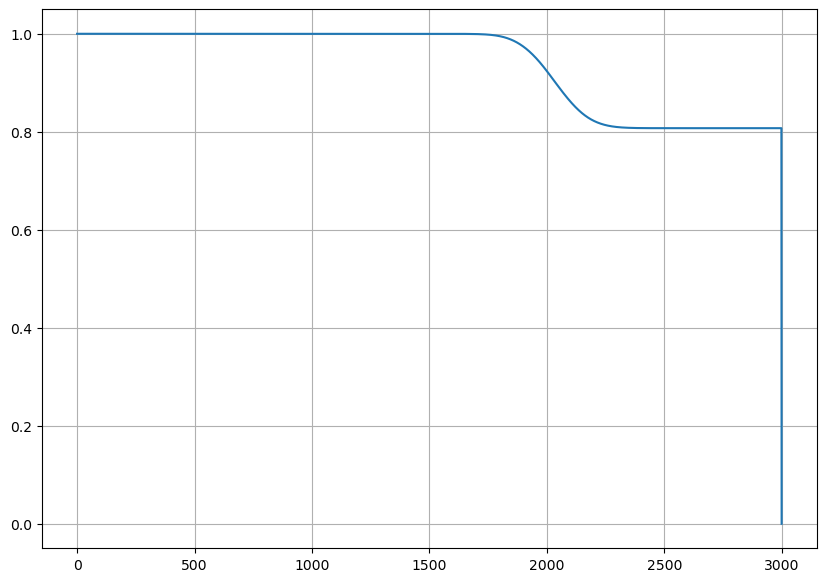

In [29]:
fig=plt.figure(figsize=(10,7)) #Size of the plot
ax=fig.add_subplot(111)
t = np.arange(0, T, 1)
plt.grid()
plt.plot(t, norm)
fig.savefig("{}.png".format(f'norma'))

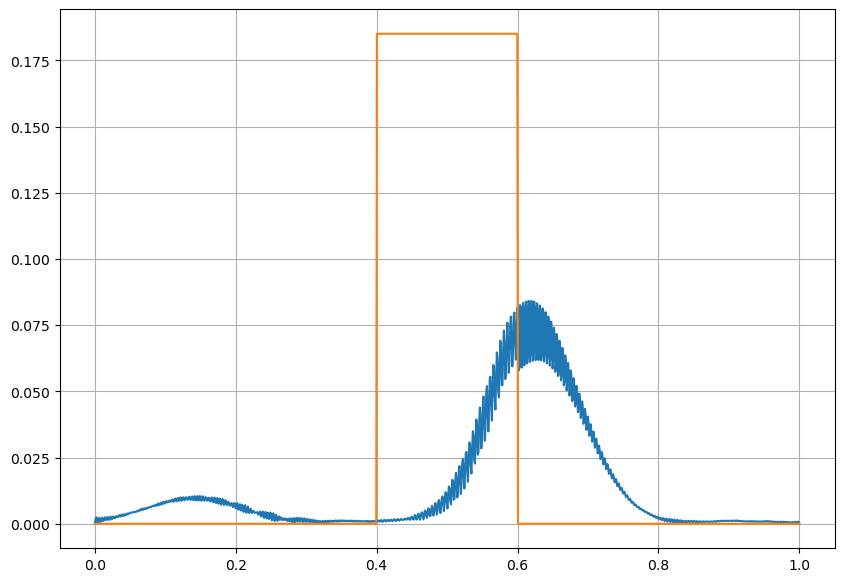

In [30]:
fig=plt.figure(figsize=(10,7)) #Size of the plot
ax=fig.add_subplot(111)

x = np.linspace(0, 1, N)
line, = ax.plot(x, prob[0])
plt.plot(x, V_prime, color='tab:orange')
plt.grid()

def animate (i, prob, line):
    line.set_ydata(prob[i])
    return line,

FFwriter = FFMpegWriter(fps=60, extra_args=['-vcodec', 'libx264'])

animation = FuncAnimation(fig, animate, fargs=(prob, line), frames=T, blit=True, interval=1)

animation.save("{}.mp4".format(f"schrodinger_"), dpi=100, writer = FFwriter)